In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mv
from matplotlib.mlab import bivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import scipy


## Part A

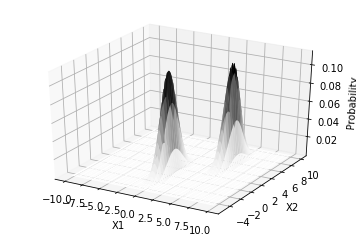

In [2]:
# Reference link: https://stackoverflow.com/a/38705297

# Creating normal functions
mu1 = np.transpose(np.array([0,0]))
mu2 = np.transpose(np.array([5,5]))

sigma = np.array([[0.25,0],[0,2]])
sigma = sigma.diagonal(0)

n1 = mv(mu1,sigma)
n2 = mv(mu2,sigma)

# Creating a grid
x1 = np.linspace(-10,10,500)
x2 = np.linspace(-5,10,500)
X1,X2 = np.meshgrid(x1,x2)
X = np.dstack((X1,X2))
Prob = 0.5*(n1.pdf(X)+n2.pdf(X))

# Plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1,X2,Prob,cmap='Greys')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Probability')
plt.show()

## Part B

In [3]:
def probFunc(X):
    # Creating normal functions
    mu1 = np.transpose(np.array([0,0]))
    mu2 = np.transpose(np.array([5,5]))
    
    # 
    sigma = np.array([[0.25,0],[0,2]])
    sigma = sigma.diagonal(0)

    n1 = mv(mu1,sigma)
    n2 = mv(mu2,sigma)

    prob = 0.5*(n1.pdf(X)+n2.pdf(X))
    
    return prob


In [96]:
def mcmc(x_int,steps=10**4,step_size=[[6,0],[0,6]]):
    '''
    MCMC two multivariate normal distributions 
    x_int is the intial values
    steps are the number of steps
    step_size is how large the steps are
    
    Will show the plots of:
    Scatter Plots
    Trace of x1 and x2
    Histogram of x1 and x2
    Histogram of acceptance or rejection
    
    Returns the 2D array of x ([x1,x2]) and the mean
    '''
    # Setting up the walker
    sigma = np.array(step_size)
    sigma = sigma.diagonal(0)
    x = x_int
    x1 = []
    x2 = []
    accept = []
    
    # Doing the burn in using 10% of the steps
    for i in range(int(.1*steps)):
        x_prime = scipy.stats.multivariate_normal(x,sigma).rvs()
        prob = probFunc(x_prime)/probFunc(x)
        if prob > 1:
            x = x_prime 
        else: 
            rand = random.uniform(0,1)    
            if rand <= prob:
                x = x_prime
            else:
                x_prime = 0
    
    # Running the MCMC
    for i in range(steps):
        x_prime = scipy.stats.multivariate_normal(x,sigma).rvs()
        prob = probFunc(x_prime)/probFunc(x)
        
        # If higher prob is higher, accepts
        if prob > 1:
            x = x_prime
            x1.append(x[0])
            x2.append(x[1])
            accept.append(1)
        
        # If less than 1, draws a random int
        else: 
            rand = random.uniform(0,1)    
            if rand <= prob: # accepts
                x = x_prime
                x1.append(x[0])
                x2.append(x[1])
                accept.append(1)
            else: # rejects
                x_prime = 0
                x1.append(x[0])
                x2.append(x[1])
                accept.append(0)
    
    # putting everything into arrays
    x1 = np.array(x1)
    x2 = np.array(x2)
    x = np.column_stack((x1,x2))
    mean = np.mean(x)

    # Plotting the scatter plot
    s = plt.figure(1)
    plt.scatter(x1,x2,color='black',s=.5)
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    s.show()
    
    # Plotting the trace
    steps = np.linspace(0,steps,steps)
    t, ax = plt.subplots(nrows=2,ncols=1,sharex=True)
    ax[0].plot(steps,x1,color='black',label='$X_1$')
    ax[1].plot(steps,x2,color='red',label='$X_2$')
    ax[0].set_ylabel('$X_1$')
    ax[1].set_ylabel('$X_2$')
    t.subplots_adjust(wspace=None)
    t.show()
    
    # Plotting the histogram of x1 and x2
    h = plt.figure(3)
    plt.hist(x1,color='black',histtype='step',bins=100,label='$X_1$')
    plt.hist(x2,color='red',histtype='step',bins=100,label='$X_2$')
    plt.legend(loc=0)
    h.show()
    
    # Plotting the acceptance
    h2 = plt.figure(4)
    plt.hist(accept,color='black',histtype='step',density=True)
    h2.show()
    
    return np.stack((x1,x2),axis=0),mean
    
    
    

/home/russell/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


2.518821941139705


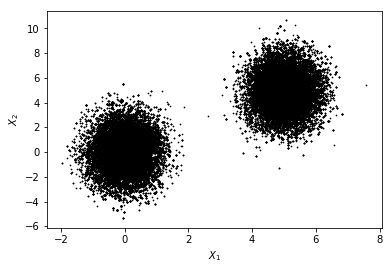

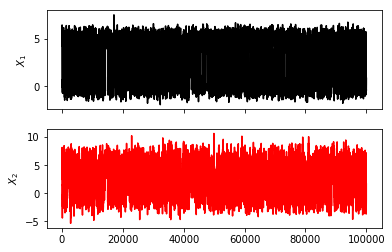

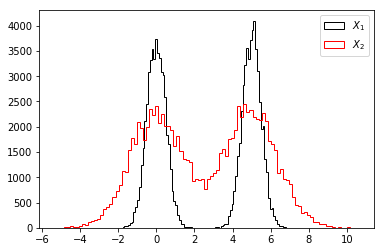

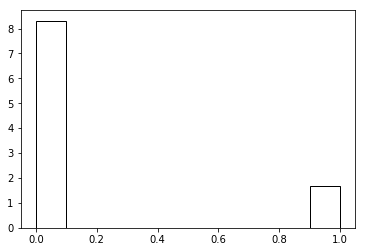

In [153]:
x,mean = mcmc([10,10],steps=10**5,step_size=[[6,0],[0,6]])
print(mean)

## Part C

In [154]:
# Creating functions to do the stuff
# Found out how to make an arbitrary number of list: 
# https://stackoverflow.com/questions/13520876/how-can-i-make-multiple-empty-lists-in-python

def partition(arr,bins):
    '''
    Breaks up an array into sub-arrays.
    If the array doesn't perfect break up, will just take the remainder at the end
    '''
    # makes list for N number of parameteres
    if len(arr) != 1:
        lists = [[] for _ in range(len(arr))]
    else:
        lists = []
        
    # Loops through each parameter and bins it up
    for i in range(len(lists)):
        # Putting the data into one array
        data = arr[i]
        
        # Placing the new array
        new_arr = lists[i]
        
        # How many time we can fully bin the array
        iterations = len(data)//bins
        
        # Partitions the array
        for j in range(iterations):
            partition = data[:bins]
            new_arr.append(partition)
            data = data[bins:]
        # Putting it back into the list 
        lists[i] = np.array(new_arr)
        
    return np.stack(lists,axis=0)

def meanError(arr,bins):
    '''
    Takes in an array resulting from an MCMC and caluclates the error associated with it 
    '''
    # This splits the array
    new_arr = partition(arr,bins)
    
    # Makes new arrays for the means
    means = [[] for _ in range(len(new_arr))]
    err = [[] for _ in range(len(new_arr))]
    
    # Takes the mean of each sub array and puts it into the mean array
    # Calculates the error through usual error estiamte: sqrt(variance/N)
    for i in range(len(means)):
        data = new_arr[i]
        for j in range(len(data)):
            means[i].append(np.mean(data[j]))
        err[i].append(np.sqrt(np.var(np.array(means[i]))/np.array(means[i]).shape[0]))
    err = np.array(err)
    means = np.array(means)
    
    # Calculates total error
    # error = sqrt(sigma_1**2+sigma_2**2+...+sigma_n**2)
    error = []
    for i in range(len(err)):
        error.append(err[i]**2)
    error = np.sqrt(np.sum(np.array(error)))/len(error)
    
    return error,means

    

In [119]:
test = partition(x,500)

In [125]:
data = test[0]
#for i in range(len(data)):
 #   means[0].append(np.mean(data[i]))
len(data)
data[20]

array([], dtype=float64)

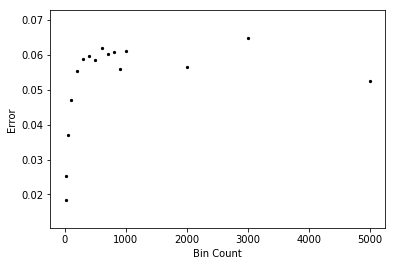

In [156]:
err = []
mean = []
bins = [10,20,50,100,200,300,400,500,600,700,800,900,1000,2000,3000,5000]

for i in bins:
    result = meanError(x,i)
    err.append(result[0])
    mean.append(result[1])
    
err = np.array(err)

plt.scatter(bins,err,color='k',marker='o',s=5)
plt.xlabel('Bin Count')
plt.ylabel('Error')
plt.show()


In [157]:
error, means = meanError(x,200)
print(error)

0.05531451729632768


## Part D

In [159]:
# Calculating the covariance 
def correlationTime(arr,n):
    '''
    Calculates the correlation time using the covariance
    '''
    # Makes covariance list
    covar = [[] for _ in range(len(arr))]
    
    # Calculates the mean
    means = np.mean(x)
    # Calculating the covariance per parameter
    for i in range(len(covar)):
        data = arr[i]
        covar[i].append((data[0:data.shape[0]-n]-means)*(data[0+n:]-means)/data.shape[0])
    
    # Summing the two covariances together
    covariance = np.sum(np.array(covar))/2
    
    return covariance
        

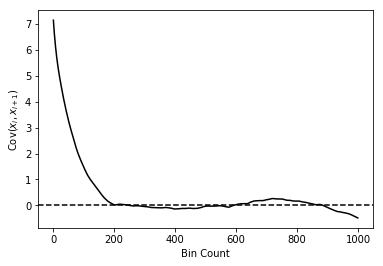

In [160]:
# Plotting the correlation time
bins = np.arange(1,1000)
corr_time = []

for i in bins:
    corr_time.append(correlationTime(x,i))

corr_time = np.array(corr_time)

plt.plot(bins,corr_time,color='black')
plt.xlabel('Bin Count')
plt.ylabel('Cov($x_i,x_{i+1}$)')
plt.axhline(y=0,color='k',linestyle='--')
plt.show()
